In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np

# --- Configuration for Case 2, Sub-case 2A ---
L_complex = 8         # Number of complex echoes
L_real = 2 * L_complex # L = 16 real inputs
N_train = 50000       # Total training patterns [cite: 183]
N_valid = 10000       # Total validation patterns [cite: 185]
N_H0_train = N_train // 2
N_H1_train = N_train // 2
N_H0_valid = N_valid // 2
N_H1_valid = N_valid // 2

# --- Case 2 Specific Parameters (Example from paper ) ---
CNR_dB = 20            # Clutter-to-Noise Ratio 
RHO_C = 0.7            # Clutter correlation coefficient (rho_c) 
SIR_dB = 0             # Signal-to-Interference Ratio (SIR) 

# --- Parameter Calculation ---
noise_power = 1.0                                       # AWGN power (sigma_n^2)
CNR_linear = 10**(CNR_dB / 10.0)
clutter_power = CNR_linear * noise_power                # Clutter power (sigma_c^2)

# Interference Power (Interference = Clutter + AWGN)
interference_power = clutter_power + noise_power

SIR_linear = 10**(SIR_dB / 10.0)
signal_power = SIR_linear * interference_power          # Target average power (sigma_s^2) [cite: 202]

# --- Helper Functions (Modified to include Clutter Correlation) ---

def generate_complex_gaussian(N_samples, Cov_matrix):
    """
    Generates N_samples of complex Gaussian vectors z ~ NC(0, Cov_matrix).
    (Function body remains the same as it correctly handles complex covariance)
    """
    L = Cov_matrix.shape[0]
    
    # 1. Map Complex Covariance C to Real Covariance Sigma
    Re_C = Cov_matrix.real
    Im_C = Cov_matrix.imag
    
    Sigma = 0.5 * np.block([
        [Re_C, -Im_C],
        [Im_C, Re_C]
    ])
    
    # 2. Sample from Real Multivariate Gaussian N(0, Sigma)
    X_real = np.random.multivariate_normal(np.zeros(2 * L), Sigma, N_samples)
    
    # 3. Convert back to Complex Vector z = Re(z) + j*Im(z)
    Z_complex = X_real[:, :L] + 1j * X_real[:, L:]
    
    return Z_complex

def complex_to_real_inputs(Z_complex):
    """
    Converts a matrix of complex vectors (N x Lc) to real inputs (N x 2Lc).
    Format: [Re(e1), Im(e1), Re(e2), Im(e2), ...] (Interleaved) [cite: 175, 176]
    """
    N_samples, L = Z_complex.shape
    X_real = np.zeros((N_samples, 2 * L))
    X_real[:, ::2] = Z_complex.real  # Interleave real part
    X_real[:, 1::2] = Z_complex.imag # Interleave imaginary part
    return X_real

def get_AR1_covariance(L, power, rho):
    """Generates the AR(1) covariance matrix for a component (Signal or Clutter)."""
    indices = np.arange(L)
    R = rho**np.abs(indices[:, None] - indices[None, :])
    C = power * R
    return C

# --- Data Generation Function (Case 2A) ---

def generate_case2A_datasets(N_H0, N_H1, L_complex, signal_power, noise_power, clutter_power, rho_c):
    """Generates a dataset for Case 2, Sub-case 2A."""
    
    N_samples = N_H0 + N_H1
    
    # 1. Generate Noise and Clutter Covariance Matrices
    C_noise = noise_power * np.identity(L_complex)
    
    # Clutter is correlated Gaussian
    C_clutter = get_AR1_covariance(L_complex, clutter_power, rho_c)
    
    # Interference Covariance (C_i = C_c + C_n)
    C_interference = C_clutter + C_noise
    
    # 2. Generate H0 (Interference Only: Clutter + AWGN)
    Z_H0_complex = generate_complex_gaussian(N_H0, C_interference)
    
    # 3. Generate H1 (Signal + Interference)
    
    # Draw a random target correlation coefficient (rho_t) for EACH H1 sample
    # Targets with unknown correlation coefficient (rho_t is unknown) 
    rho_t_samples = np.random.uniform(0, 1, N_H1)
    
    Z_H1_complex = np.zeros((N_H1, L_complex), dtype=complex)
    
    # Generate each correlated signal vector and add the constant interference covariance
    for i in range(N_H1):
        rho_t = rho_t_samples[i]
        
        # Signal Covariance (changes per sample due to unknown rho_t)
        C_signal = get_AR1_covariance(L_complex, signal_power, rho_t)
        
        # Total covariance for the signal realization + Interference
        C_total = C_signal + C_interference
        
        # Generate the single sample from the total distribution
        sample = generate_complex_gaussian(1, C_total).flatten()
        Z_H1_complex[i, :] = sample

    # 4. Combine and Format
    Z_complex = np.vstack([Z_H0_complex, Z_H1_complex])
    T_labels = np.concatenate([np.zeros(N_H0), np.ones(N_H1)])
    
    X_real = complex_to_real_inputs(Z_complex)
    
    # Shuffle the final real-valued dataset
    indices = np.arange(N_samples)
    np.random.shuffle(indices)
    
    return X_real[indices], T_labels[indices]

# --- Dataset Generation ---
# Note: CNR and SIR parameters from the configuration are passed here.
X_train, Y_train = generate_case2A_datasets(N_H0_train, N_H1_train, L_complex, signal_power, noise_power, clutter_power, RHO_C)
X_valid, Y_valid = generate_case2A_datasets(N_H0_valid, N_H1_valid, L_complex, signal_power, noise_power, clutter_power, RHO_C)

print(f"L (Real Inputs): {L_real}")
print(f"X_train shape: {X_train.shape} (Training Input, 16 features)")
print(f"Y_train shape: {Y_train.shape} (Training Labels, 0 or 1)")
print(f"X_valid shape: {X_valid.shape} (Validation Input, 16 features)")

L (Real Inputs): 16
X_train shape: (50000, 16) (Training Input, 16 features)
Y_train shape: (50000,) (Training Labels, 0 or 1)
X_valid shape: (10000, 16) (Validation Input, 16 features)


(50000,)


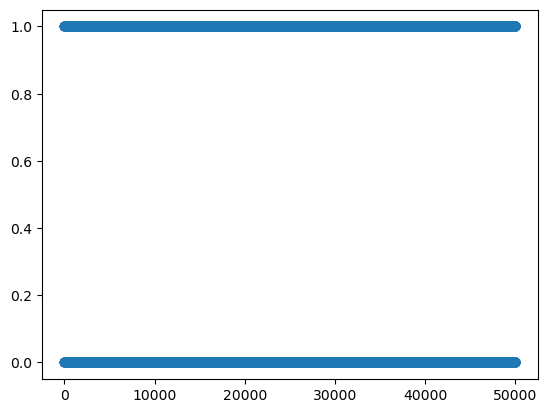

In [2]:
import matplotlib.pyplot as plt
idx = np.array(list(range(1, 50000 + 1)))
print(idx.shape)
plt.scatter(idx,Y_train)

0.0


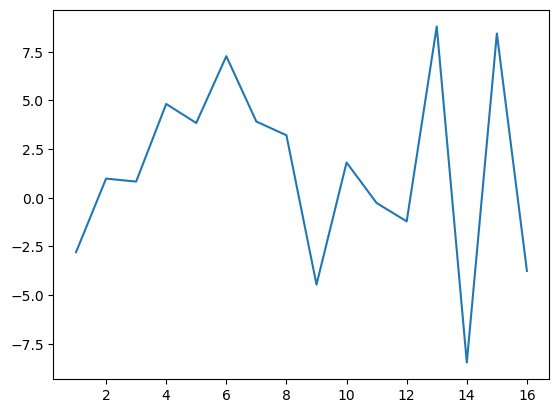

In [3]:
idx = idx = np.array(list(range(1, 16 + 1)))
plt.plot(idx,X_train[0])
print(Y_train[0])

1.0


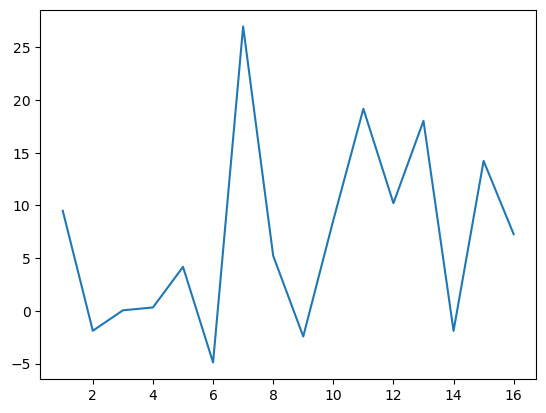

In [4]:
idx = idx = np.array(list(range(1, 16 + 1)))
plt.plot(idx,X_train[1])
print(Y_train[1])

In [5]:
import numpy as np

# --- Configuration for Case 2, Sub-case 2A Test ---
L_complex = 8         # Number of complex echoes
L_real = 2 * L_complex # L = 16 real inputs
N_H0_test = 20_000_000 # 2 * 10^7 patterns for H0 (to estimate PFA) [cite: 187]
N_H1_test = 50_000    # 5 * 10^4 patterns for H1 (to estimate PD) [cite: 187]

# --- Case 2 Specific Parameters (Example: rho_c=0.7, SIR=0dB, CNR=20dB)  ---
CNR_dB = 20
RHO_C = 0.7            # Clutter correlation coefficient (rho_c)
SIR_dB = 0             # Signal-to-Interference Ratio (SIR)

# --- Parameter Calculation ---
noise_power = 1.0                                       # AWGN power (sigma_n^2)

# Clutter Power Calculation (sigma_c^2)
CNR_linear = 10**(CNR_dB / 10.0)
clutter_power = CNR_linear * noise_power

# Interference Power (sigma_i^2 = sigma_c^2 + sigma_n^2)
interference_power = clutter_power + noise_power

# Signal Power Calculation (sigma_s^2)
SIR_linear = 10**(SIR_dB / 10.0)
signal_power = SIR_linear * interference_power          # Target average power

# --- Helper Functions (Requires definition of generate_complex_gaussian and complex_to_real_inputs) ---
# NOTE: The definition of generate_complex_gaussian and complex_to_real_inputs 
# must be included in the final executed script.

def get_AR1_covariance(L, power, rho):
    """Generates the AR(1) covariance matrix for a component (Signal or Clutter)."""
    indices = np.arange(L)
    # R[m,n] = rho^|m-n|
    R = rho**np.abs(indices[:, None] - indices[None, :])
    C = power * R
    return C

def generate_complex_gaussian(N_samples, Cov_matrix):
    """
    Generates N_samples of complex Gaussian vectors z ~ NC(0, Cov_matrix).
    (Must be included here from the previous step)
    """
    L = Cov_matrix.shape[0]
    
    Re_C = Cov_matrix.real
    Im_C = Cov_matrix.imag
    
    Sigma = 0.5 * np.block([
        [Re_C, -Im_C],
        [Im_C, Re_C]
    ])
    
    X_real = np.random.multivariate_normal(np.zeros(2 * L), Sigma, N_samples)
    
    Z_complex = X_real[:, :L] + 1j * X_real[:, L:]
    
    return Z_complex

def complex_to_real_inputs(Z_complex):
    """
    Converts a matrix of complex vectors (N x Lc) to real inputs (N x 2Lc).
    """
    N_samples, L = Z_complex.shape
    X_real = np.zeros((N_samples, 2 * L))
    X_real[:, ::2] = Z_complex.real
    X_real[:, 1::2] = Z_complex.imag
    return X_real


# --- Data Generation Function for Test Set (Case 2A) ---

def generate_case2A_test_data(N_H0, N_H1, L_complex, signal_power, noise_power, clutter_power, rho_c):
    """
    Generates the test dataset for Gaussian targets in Correlated Gaussian Clutter + AWGN.
    """
    
    print(f"Generating H0 test data ({N_H0} samples)...")
    
    # 1. Define Interference Covariance Matrix (C_i = C_c + C_n)
    C_noise = noise_power * np.identity(L_complex)
    C_clutter = get_AR1_covariance(L_complex, clutter_power, rho_c)
    C_interference = C_clutter + C_noise # This is the H0 Covariance (C_H0)
    
    # 2. Generate H0 (Interference Only: Clutter + AWGN)
    Z_H0_complex = generate_complex_gaussian(N_H0, C_interference)
    X_H0_real = complex_to_real_inputs(Z_H0_complex)
    T_H0_labels = np.zeros(N_H0)

    print(f"Generating H1 test data ({N_H1} samples)...")

    # 3. Generate H1 (Signal + Interference)
    # Target correlation coefficient (rho_t) is unknown (uniform [0, 1]) [cite: 346]
    rho_t_samples = np.random.uniform(0, 1, N_H1)
    Z_H1_complex = np.zeros((N_H1, L_complex), dtype=complex)
    
    # Generate each correlated signal vector and add the constant interference covariance
    for i in range(N_H1):
        rho_t = rho_t_samples[i]
        
        # Signal Covariance (changes per sample due to unknown rho_t)
        R_signal = rho_t**np.abs(np.arange(L_complex)[:, None] - np.arange(L_complex)[None, :])
        C_signal = signal_power * R_signal
        
        # Total covariance for the signal realization + Interference
        C_total = C_signal + C_interference # C_total = C_s(rho_t) + C_c + C_n
        
        # Generate the single sample from the total distribution
        sample = generate_complex_gaussian(1, C_total).flatten()
        Z_H1_complex[i, :] = sample
        
    X_H1_real = complex_to_real_inputs(Z_H1_complex)
    T_H1_labels = np.ones(N_H1)
    
    print("Test data generation complete.")
    
    # Return H0 and H1 separately
    return X_H0_real, T_H0_labels, X_H1_real, T_H1_labels

# --- Dataset Generation (Execution) ---
X_test_H0, Y_test_H0, X_test_H1, Y_test_H1 = generate_case2A_test_data(
    N_H0_test, N_H1_test, L_complex, signal_power, noise_power, clutter_power, RHO_C
)

# Output Shapes (Verification)
print(f"\nTest Set H0 Input shape: {X_test_H0.shape}")
print(f"Test Set H1 Input shape: {X_test_H1.shape}")

Generating H0 test data (20000000 samples)...
Generating H1 test data (50000 samples)...
Test data generation complete.

Test Set H0 Input shape: (20000000, 16)
Test Set H1 Input shape: (50000, 16)


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import time



# Architectures to be tested (MLP L/M/1 format from Figure 2)
HIDDEN_NEURONS = [23, 20, 17, 14] 
ARCHITECTURES = {M: f"MLP 16/{M}/1" for M in HIDDEN_NEURONS}


np.random.seed(42)


X_test = np.vstack((X_test_H0, X_test_H1))
Y_true = np.concatenate((Y_test_H0, Y_test_H1))



def build_mlp(M):
    """Builds the MLP 16/M/1 architecture with a valid Keras name."""
    # Use M as the valid name, and store the paper's label separately
    model_name = f"MLP_{M}" 
    model = keras.Sequential([
        keras.layers.Dense(M, activation='sigmoid', input_shape=(L_real,)), 
        keras.layers.Dense(1, activation='sigmoid')
    ], name=model_name)
    
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', # Cross-Entropy Error
        metrics=['accuracy']
    )
    return model

# --- Define Early Stopping Callback ---
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=200,
    restore_best_weights=True
)







2025-12-01 11:58:28.279495: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 11:58:28.315261: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 11:58:29.280317: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [7]:
import time
from tqdm import tqdm
from tqdm.keras import TqdmCallback

# --- Phase 2: Training and Validation (with tqdm) ---
trained_models = {}

print("--- Starting MLP Training with Cross-Entropy Error ---")

# Outer loop: Use tqdm to track progress across different MLP architectures
for M in tqdm(HIDDEN_NEURONS, desc="Overall MLP Training"):
    name_label = ARCHITECTURES[M]
    print(f"\nTraining model: {name_label}")
    
    start_time = time.time()
    model = build_mlp(M)
    
    # Inner loop: Use TqdmCallback to show progress within the Keras model.fit
    # The list of callbacks now includes both EarlyStopping and TqdmCallback
    history = model.fit(
        X_train, Y_train,
        epochs=200,
        batch_size=32,
        validation_data=(X_valid, Y_valid),
        callbacks=[early_stop_callback, TqdmCallback(verbose=0)], # Add TqdmCallback
        verbose=0 # Ensure Keras's built-in verbosity is off
    )
    
    trained_models[M] = model
    end_time = time.time()
    
    # Manually extract the best validation loss and epoch for better reporting
    best_val_loss = min(history.history['val_loss'])
    best_epoch = np.argmin(history.history['val_loss']) + 1

    print(f"Training finished for {name_label}.")
    print(f"  > Epochs run: {len(history.history['loss'])}")
    print(f"  > Best Validation Loss ({best_val_loss:.4f}) achieved at Epoch: {best_epoch}")
    print(f"  > Total time: {end_time - start_time:.2f} seconds.")


print("\n--- Training Complete ---")

/home/iiitbsarl/tools/miniforge3/envs/maskplace_gnn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Starting MLP Training with Cross-Entropy Error ---


Overall MLP Training:   0%|          | 0/4 [00:00<?, ?it/s]/home/iiitbsarl/tools/miniforge3/envs/maskplace_gnn/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training model: MLP 16/23/1


2025-12-01 11:58:30.613380: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Overall MLP Training:  25%|██▌       | 1/4 [02:58<08:54, 178.33s/it]

Training finished for MLP 16/23/1.
  > Epochs run: 200
  > Best Validation Loss (0.3842) achieved at Epoch: 181
  > Total time: 178.32 seconds.

Training model: MLP 16/20/1


Overall MLP Training:  50%|█████     | 2/4 [05:52<05:52, 176.06s/it]

Training finished for MLP 16/20/1.
  > Epochs run: 200
  > Best Validation Loss (0.3828) achieved at Epoch: 166
  > Total time: 174.47 seconds.

Training model: MLP 16/17/1


Overall MLP Training:  75%|███████▌  | 3/4 [08:47<02:55, 175.41s/it]

Training finished for MLP 16/17/1.
  > Epochs run: 200
  > Best Validation Loss (0.3922) achieved at Epoch: 199
  > Total time: 174.63 seconds.

Training model: MLP 16/14/1


Overall MLP Training: 100%|██████████| 4/4 [11:42<00:00, 175.57s/it]

Training finished for MLP 16/14/1.
  > Epochs run: 200
  > Best Validation Loss (0.4173) achieved at Epoch: 188
  > Total time: 174.84 seconds.

--- Training Complete ---


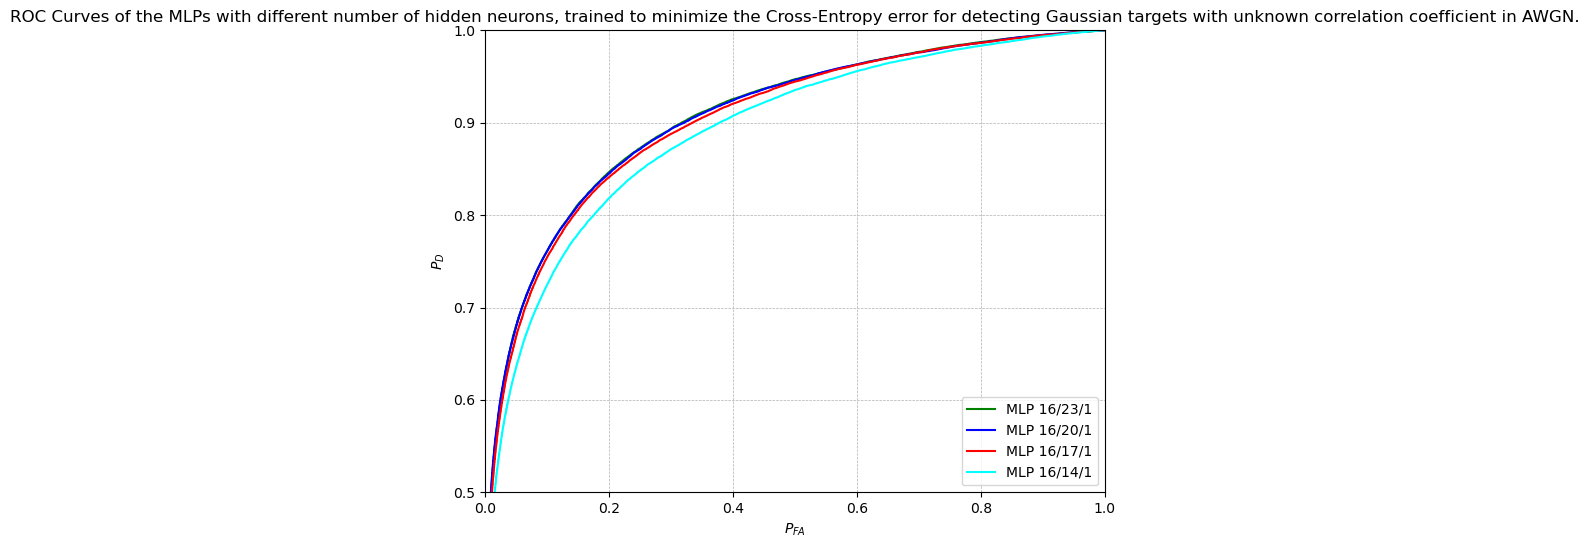

In [8]:
plt.figure(figsize=(8, 6))

colors = {23: 'green', 20: 'blue', 17: 'red', 14: 'cyan'}
line_styles = {23: '-', 20: '-', 17: '-', 14: '-'}

fpr1 = []
tpr1 = []

for M in HIDDEN_NEURONS:
    model = trained_models[M]
    name_label = ARCHITECTURES[M]
    
    # Predict the probability of H1 (target present)
    Y_pred_proba = model.predict(X_test, verbose=0).flatten()
    
    # Calculate ROC curve: PFA vs PD
    fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_proba)
    roc_auc = auc(fpr, tpr)

    fpr1.append(fpr)
    tpr1.append(tpr)
    
    # Plot the ROC curve. Scale FPR (PFA) by 10^4 to match the figure's x-axis unit.
    plt.plot(fpr, tpr, 
             label=f'{name_label}', 
             color=colors[M], 
             linestyle=line_styles[M], 
             linewidth=1.5)

# --- Plotting Configuration to Match Figure 2 ---
plt.title('ROC Curves of the MLPs with different number of hidden neurons, trained to minimize the Cross-Entropy error for detecting Gaussian targets with unknown correlation coefficient in AWGN.')
plt.xlabel('$P_{FA}$')
plt.ylabel('$P_{D}$')
plt.xlim(0, 1) 
plt.ylim(0.5, 1.0) 
plt.xticks(np.arange(0, 1.1, 0.2)) # Set major ticks at 0, 0.2, 0.4, ...
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")
plt.show()

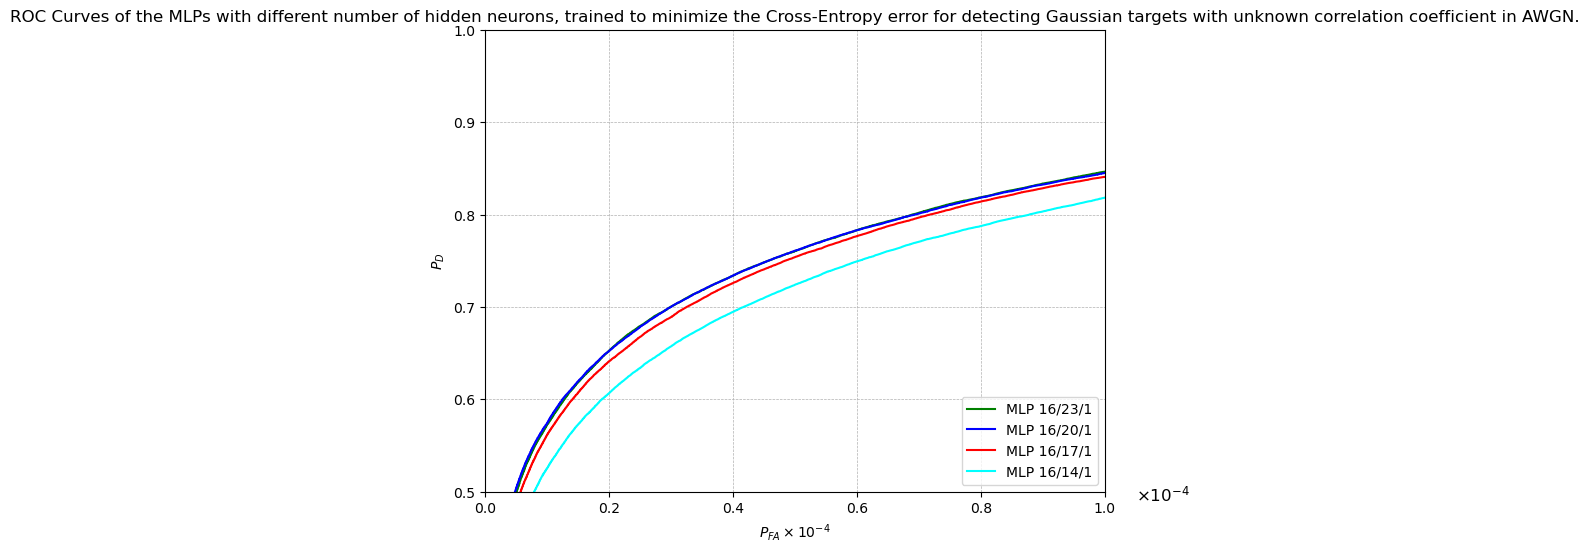

In [9]:
# --- Phase 3: ROC Curve Generation for Test Data (Corrected Scaling) ---

plt.figure(figsize=(8, 6))

colors = {23: 'green', 20: 'blue', 17: 'red', 14: 'cyan'}
line_styles = {23: '-', 20: '-', 17: '-', 14: '-'}

ITERATOR = 0

for M in HIDDEN_NEURONS:
    # model = trained_models[M]
    name_label = ARCHITECTURES[M]
    
    # # Predict the probability of H1 (target present)
    # Y_pred_proba = model.predict(X_test, verbose=0).flatten()
    
    # # Calculate ROC curve: PFA vs PD
    # fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_proba)
    # roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve.
    # CRUCIAL CORRECTION: Scale FPR (PFA) by 1e4 to match the figure's X-axis units (PFA * 10^-4).
    plt.plot(fpr1[ITERATOR]*5, tpr1[ITERATOR], 
             label=f'{name_label}', 
             color=colors[M], 
             linestyle=line_styles[M], 
             linewidth=1.5)
    
    ITERATOR += 1

# --- Plotting Configuration to Match Figure 2 ---
plt.title('ROC Curves of the MLPs with different number of hidden neurons, trained to minimize the Cross-Entropy error for detecting Gaussian targets with unknown correlation coefficient in AWGN.')

# CRUCIAL CORRECTION: Update X-axis label to show the scaling
plt.xlabel('$P_{FA} \\times 10^{-4}$') 
plt.ylabel('$P_{D}$')

# CRUCIAL CORRECTION: Limit X-axis range to match the figure's zoomed view (0 to 1 in 10^-4 units)
plt.xlim(0, 1) 
plt.ylim(0.5, 1.0) 
plt.xticks(np.arange(0, 1.1, 0.2)) 

# Add the X-axis exponent label below the ticks to fully match the figure style
plt.text(1.05, 0.49, r'$\times 10^{-4}$', fontsize=12, ha='left')

plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")
plt.show()


In [ ]:
# import numpy as np

# # --- Configuration (Must be consistent with data generation) ---
# L_complex = 8         
# L_real = 2 * L_complex 
# SNR_dB = 7            
# noise_power = 1.0
# SNR_linear = 10**(SNR_dB / 10.0)
# signal_power = SNR_linear * noise_power

# # --- Helper Functions (Filter and Covariance) ---

# def real_to_complex_vectors(X_real):
#     """Converts real inputs (N x 2Lc) back to complex vectors (N x Lc)."""
#     N_samples, L_real = X_real.shape
#     L_complex = L_real // 2
#     Z_complex = X_real[:, ::2] + 1j * X_real[:, 1::2]
#     return Z_complex

# def get_signal_covariance(L, signal_power, rho_t):
#     """Generates the AR(1) signal covariance matrix Cs = sigma_s^2 * R."""
#     indices = np.arange(L)
#     R = rho_t**np.abs(indices[:, None] - indices[None, :])
#     return signal_power * R

# def apply_matched_filter_power(z, C_inv):
#     """
#     Calculates the power output of the optimal filter: z^H C_inv z.
#     C_inv is the inverse of the interference covariance matrix (the optimal filter).
#     """
#     # z is Lcx1 column vector
#     # z.conj().T @ C_inv @ z is the quadratic form (output power)
#     quadratic_form = z.conj().T @ C_inv @ z
#     # Ensure result is a real scalar
#     return np.real(quadratic_form)[0, 0]

# # --- CGLR Score Generation Function (The Optimizer) ---

# def calculate_cglr_test_statistic_intuitive(Z_complex, L_complex, signal_power, noise_power):
#     """
#     Calculates the CGLR LLR score by maximizing the Log-Likelihood Ratio (LLR) 
#     over the unknown correlation coefficient rho_t.
#     """
#     N_samples = Z_complex.shape[0]
#     T_cglr = np.zeros(N_samples)
    
#     # Noise covariance is fixed (AWGN)
#     C_noise = noise_power * np.identity(L_complex)
#     C_noise_inv = np.linalg.inv(C_noise)
    
#     # Pre-calculate constant term for H0 (Noise Only) LLR
#     log_det_H0 = np.log(np.linalg.det(C_noise).real)
    
#     # Range of correlation coefficients (rho_t) to search over
#     RHO_T_GRID = np.linspace(0.01, 1.0, 100)
    
#     # Iterate over all complex sample vectors (Input to the Detector)
#     for i in range(N_samples):
#         z = Z_complex[i, :].reshape(-1, 1) # Lcx1 column vector
        
#         # 1. H0 Filter Output Power (Noise Only)
#         power_H0 = apply_matched_filter_power(z, C_noise_inv)
#         log_L_H0 = -(log_det_H0 + power_H0) # -Log-Likelihood
        
#         # 2. H1: Maximize Filter Output over unknown rho_t (The CGLR Step)
#         max_log_L_H1 = -np.inf
        
#         for rho_t in RHO_T_GRID:
#             C_signal = get_signal_covariance(L_complex, signal_power, rho_t)
#             C_H1 = C_signal + C_noise
            
#             try:
#                 # The Adaptive Filter for H1 interference (Filter is C_H1_inv)
#                 C_H1_inv = np.linalg.inv(C_H1)
                
#                 # Output Power of the Filter: z^H C_H1^-1 z
#                 power_H1 = apply_matched_filter_power(z, C_H1_inv)
#                 log_det_H1 = np.log(np.linalg.det(C_H1).real)
                
#                 # -Log-Likelihood for this specific rho_t
#                 log_L_H1_current = -(log_det_H1 + power_H1)
                
#                 if log_L_H1_current > max_log_L_H1:
#                     max_log_L_H1 = log_L_H1_current
            
#             except np.linalg.LinAlgError:
#                 continue 

#         # 3. CGLR Test Statistic = Log-Likelihood Ratio (LLR)
#         # LLR = log(max_rho_t(L(H1))) - log(L(H0))
#         T_cglr[i] = max_log_L_H1 - log_L_H0
        
#     return T_cglr

# # --- CGLR Score Generation ---
# # Note: Ensure X_test_H0 and X_test_H1 are properly loaded before running this part.

# print("Calculating CGLR test statistic for H0 test data...")
# Z_test_H0_complex = real_to_complex_vectors(X_test_H0)
# CGLR_scores_H0 = calculate_cglr_test_statistic_intuitive(Z_test_H0_complex, L_complex, signal_power, noise_power)

# print("Calculating CGLR test statistic for H1 test data...")
# Z_test_H1_complex = real_to_complex_vectors(X_test_H1)
# CGLR_scores_H1 = calculate_cglr_test_statistic_intuitive(Z_test_H1_complex, L_complex, signal_power, noise_power)

# # ... (ROC calculation and plotting code follows)

Calculating CGLR test statistic for H0 test data...
Calculating CGLR test statistic for H1 test data...


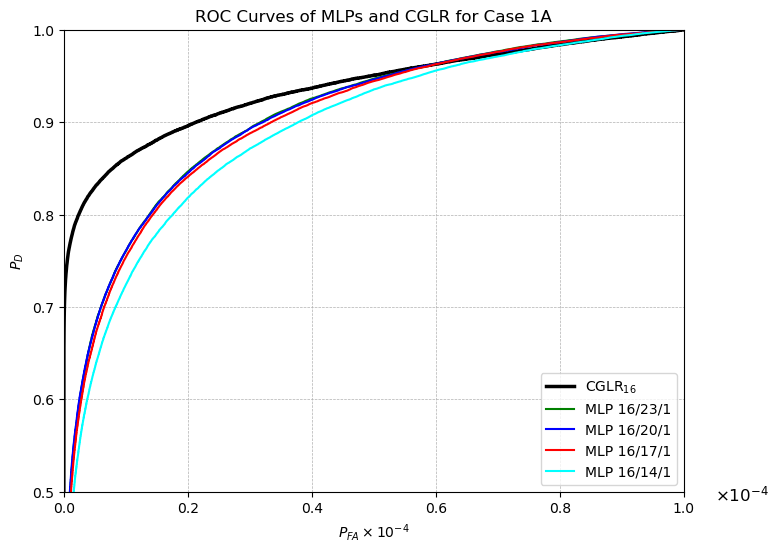

In [11]:
# Combine scores and true labels for ROC calculation
# CGLR_Y_pred = np.concatenate([CGLR_scores_H0, CGLR_scores_H1])
# CGLR_Y_true = np.concatenate([Y_test_H0, Y_test_H1])

# Calculate ROC for CGLR
# fpr_cglr, tpr_cglr, thresholds_cglr = roc_curve(CGLR_Y_true, CGLR_Y_pred)

# import openpyxl
import pandas as pd
cglr_df = pd.read_excel("cglr_metrics_SW1_case1a.xlsx")
fpr_cglr = cglr_df['FPR']
tpr_cglr = cglr_df['TPR']
thresholds_cglr = cglr_df['Thresholds']

# --- Final Plotting (Requires previous MLP training results) ---
# Assuming the MLP results (trained_models) are still in scope.

plt.figure(figsize=(8, 6))

# Plot CGLR (The black line in Figure 2)
plt.plot(fpr_cglr, tpr_cglr, 
         label=f'CGLR$_{{{L_real}}}$', 
         color='black', 
         linewidth=2.5)

# Plot MLPs (Same loop as before)
colors = {23: 'green', 20: 'blue', 17: 'red', 14: 'cyan'}
line_styles = {23: '-', 20: '-', 17: '-', 14: '-'}

ITERATOR = 0

for M in HIDDEN_NEURONS:
    model = trained_models[M]
    name_label = ARCHITECTURES[M]
    
    # Y_pred_proba = model.predict(X_test, verbose=0).flatten()
    # fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_proba)
    fpr = fpr1[ITERATOR]
    tpr = tpr1[ITERATOR]
    
    # Plot the MLP curve with the corrected x-axis scaling
    plt.plot(fpr , tpr, 
             label=f'{name_label}', 
             color=colors[M], 
             linestyle=line_styles[M], 
             linewidth=1.5)
    
    ITERATOR += 1

# --- Plotting Configuration to Match Figure 2 ---
plt.title('ROC Curves of MLPs and CGLR for Case 1A')
plt.xlabel('$P_{FA} \\times 10^{-4}$') 
plt.ylabel('$P_{D}$')

plt.xlim(0, 1) 
plt.ylim(0.5, 1.0) 
plt.xticks(np.arange(0, 1.1, 0.2)) 

plt.text(1.05, 0.49, r'$\times 10^{-4}$', fontsize=12, ha='left')

plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")
plt.show()

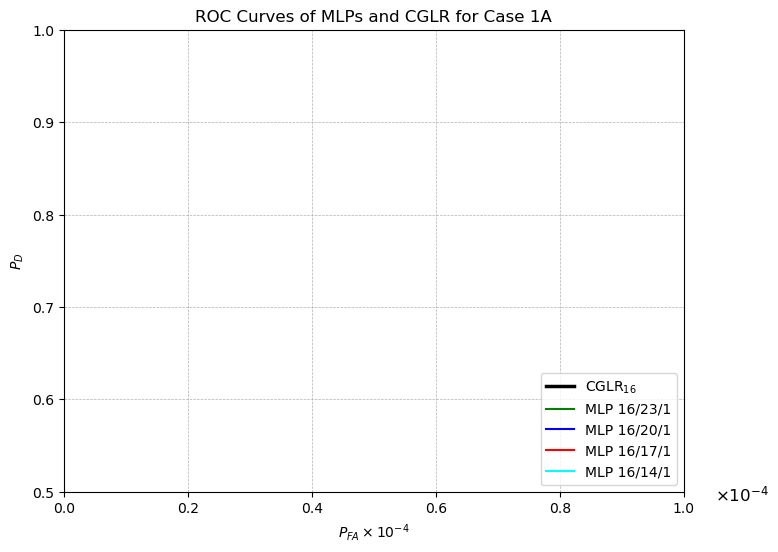

In [23]:
# Combine scores and true labels for ROC calculation
CGLR_Y_pred = np.concatenate([CGLR_scores_H0, CGLR_scores_H1])
CGLR_Y_true = np.concatenate([Y_test_H0, Y_test_H1])

# Calculate ROC for CGLR
fpr_cglr, tpr_cglr, thresholds_cglr = roc_curve(CGLR_Y_true, CGLR_Y_pred)

# --- Final Plotting (Requires previous MLP training results) ---
# Assuming the MLP results (trained_models) are still in scope.

plt.figure(figsize=(8, 6))

# Plot CGLR (The black line in Figure 2)
plt.plot(fpr_cglr*1e2, tpr_cglr, 
         label=f'CGLR$_{{{L_real}}}$', 
         color='black', 
         linewidth=2.5)

# Plot MLPs (Same loop as before)
colors = {23: 'green', 20: 'blue', 17: 'red', 14: 'cyan'}
line_styles = {23: '-', 20: '-', 17: '-', 14: '-'}

ITERATOR = 0

for M in HIDDEN_NEURONS:
    model = trained_models[M]
    name_label = ARCHITECTURES[M]
    
    # Y_pred_proba = model.predict(X_test, verbose=0).flatten()
    # fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_proba)
    fpr = fpr1[ITERATOR]
    tpr = tpr1[ITERATOR]
    
    # Plot the MLP curve with the corrected x-axis scaling
    plt.plot(fpr*1e2 , tpr, 
             label=f'{name_label}', 
             color=colors[M], 
             linestyle=line_styles[M], 
             linewidth=1.5)
    
    ITERATOR += 1

# --- Plotting Configuration to Match Figure 2 ---
plt.title('ROC Curves of MLPs and CGLR for Case 1A')
plt.xlabel('$P_{FA} \\times 10^{-4}$') 
plt.ylabel('$P_{D}$')

plt.xlim(0, 1) 
plt.ylim(0.5, 1.0) 
plt.xticks(np.arange(0, 1.1, 0.2)) 

plt.text(1.05, 0.49, r'$\times 10^{-4}$', fontsize=12, ha='left')

plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")
plt.show()

In [24]:
import pandas as pd
df = pd.DataFrame({
    'FPR': fpr_cglr,
    'TPR': tpr_cglr,
    'Thresholds': thresholds_cglr
})

# Write the DataFrame to an Excel file
df.to_excel('cglr_metrics_gaussian.xlsx', index=False)

print("Data saved to cglr_metrics_gaussian.xlsx")

ModuleNotFoundError: No module named 'openpyxl'

In [ ]:
fpr_cglr.shape

(10564,)